In [ ]:
# !tar -xvzf features.tar.gz

In [1]:
import os
for file in os.listdir("./data/context"):
    if not file.endswith(".jpg"):
        print(file)
        break

images


In [2]:
len(os.listdir("./data/context"))

4

In [2]:
import os
import cv2
import shutil
import random

import json
import numpy as np
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchsummary import summary
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


from tqdm import tqdm
from copy import deepcopy
import sklearn.metrics
from sklearn.metrics import classification_report

/scratch/miniconda3/envs/fine_grained/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import warnings
warnings.filterwarnings("ignore")

## dataset class

#### bottle dataset

[INFO]: split: 0 | path: ./data/context/
[INFO]: mode: train | split_file: ./data/context//split_0.json
Total num classes: 28


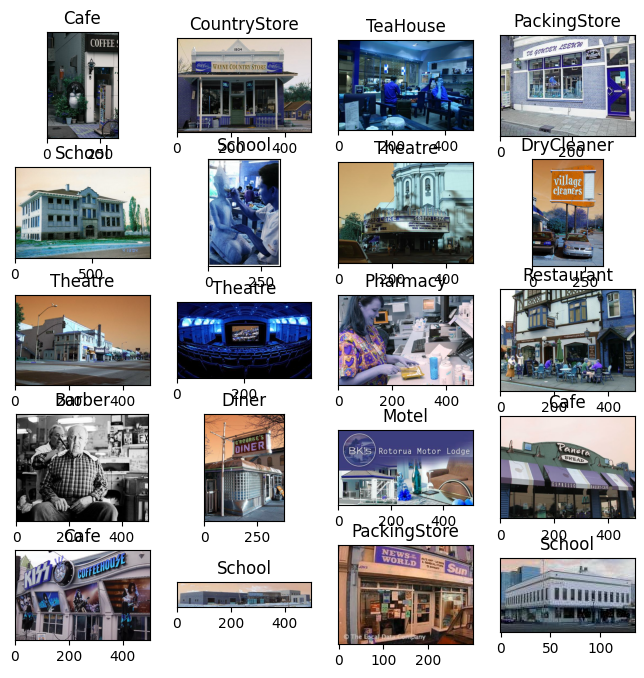


class distribution with data size of:  16179


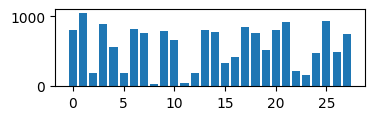

----------------------------------------------------
[INFO]: split: 1 | path: ./data/context/
[INFO]: mode: test | split_file: ./data/context//split_1.json
Total num classes: 28


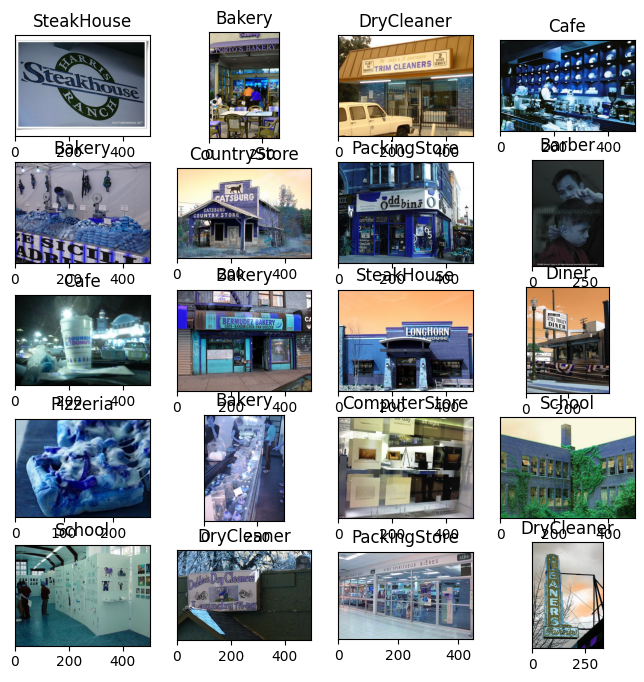


class distribution with data size of:  8076


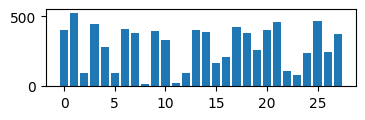

----------------------------------------------------


In [4]:
class CommonDataset(Dataset):
  def __init__(self, data_path="./data", split=0, mode="train", verbose=1):
    
    self.split = split
    self.mode = mode
    self.data_path = data_path

    print(f"[INFO]: split: {split} | path: {data_path}")
    print(f"[INFO]: mode: {mode} | split_file: {self.data_path +'/split_'+ str(self.split) +'.json'}")

    with open(self.data_path +'/split_'+ str(self.split) +'.json','r') as fp:
        self.gt_annotations = json.load(fp)
      
    with open(self.data_path + '/classes.json','r') as fp:
        self.classes_labels = json.load(fp)

    if self.mode == "train":
      self.transform = transforms.Compose([
          transforms.Resize((256, 256)),
          transforms.RandomRotation(degrees=15),
          transforms.ColorJitter(),
          transforms.RandomHorizontalFlip(),
          transforms.RandomCrop(224),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
      ])
    else:
      self.transform = transforms.Compose([
          transforms.Resize((224, 224)),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
      ])

    self.image_list = list(self.gt_annotations[self.mode].keys())
    self.num_classes = len(Counter(self.gt_annotations[self.mode].values()))
    print(f"Total num classes: {self.num_classes}")
    if verbose:
      self.visalize()

  def visalize(self, w=50, h=50, columns=4, rows=5):
    w = 20
    h = 20
    fig = plt.figure(figsize=(8, 8))
    for i in range(1, columns*rows +1):
        idx = np.random.randint(1, len(self.image_list)-1)
        img = cv2.imread(os.path.join(self.data_path, self.image_list[idx]))
        fig.add_subplot(rows, columns, i)
        plt.title(self.classes_labels[self.gt_annotations[self.mode][self.image_list[idx]]])
        plt.gca().axes.get_yaxis().set_visible(False)
        plt.imshow(img)
    
    plt.show()
    data_dist = Counter(self.gt_annotations[self.mode].values())
    print("\nclass distribution with data size of: ", sum(data_dist.values()))
    plt.figure(figsize=(4, 1))
    plt.bar(range(len(data_dist)), list(data_dist.values()), align='center')
    plt.show()
    print("----------------------------------------------------")
    
  def __len__(self):
    return len(self.gt_annotations[self.mode])

  def __getitem__(self, idx):
    image_name = self.image_list[idx]
    img = Image.open(os.path.join(self.data_path, image_name)).convert('RGB')
    # print(os.path.join(self.data_path, image_name))
    img_class = self.gt_annotations[self.mode][image_name]
    label = np.zeros(self.num_classes)
    label[int(img_class) - 1] = 1
    label = torch.from_numpy(label)
    label = label.type(torch.FloatTensor)
    label_name = self.classes_labels[img_class]

    if self.transform:
      img = self.transform(img)
      
    return img, label, label_name

dataset = CommonDataset(data_path="./data/context/", mode="train", split=0)
dataset = CommonDataset(data_path="./data/context/", mode="test", split=1)

## helper functions

In [5]:
def get_dataloaders(names=['bottle'], verbose=1,
                    train_batch_size=128, val_batch_size=16,
                    config_dict={
                        "bottle":{"path":"./data/bottle/", "split":0},
                        "activity":{"path":"./data/activity", "split":0}, 
                        "context":{"path":"./data/context","split":0}},
                    ):
                    
    output_dict = {}

    for d_type in names:

        data_path = config_dict[d_type]['path']
        train_dataset = None
        val_dataset = None
        
        if d_type == "bottle":
            train_dataset = CommonDataset(data_path, mode='train',
                                          split=config_dict[d_type]['split'],
                                          verbose=verbose)
                                          
            val_dataset = CommonDataset(data_path, mode='test',
                                        split=config_dict[d_type]['split'],
                                        verbose=verbose)
        elif d_type == "activity":
            pass

        else:
            train_dataset = CommonDataset(data_path, mode='train',
                                          split=config_dict[d_type]['split'],
                                          verbose=verbose)
                                          
            val_dataset = CommonDataset(data_path, mode='test',
                                        split=config_dict[d_type]['split'],
                                        verbose=verbose)

        if train_dataset is None or val_dataset is None:
            output_dict[d_type] = {"train":None, "test":None, "num_classes":None}
            
        else:
            train_dataloader = DataLoader(
                    dataset=train_dataset, batch_size=train_batch_size, shuffle=True)
            val_dataloader = DataLoader(
                    dataset=val_dataset, batch_size=val_batch_size, shuffle=True)

            output_dict[d_type] = {"train":train_dataloader, "test":val_dataloader, "num_classes":train_dataset.num_classes}

    return output_dict

In [6]:
def precision_recall_curve(y_true, pred_scores, thresholds, num_classes=20):
    precisions = []
    recalls = []

    for threshold in thresholds:
        y_pred = ["positive" if score >= threshold else "negative" for score in pred_scores]

        precision = sklearn.metrics.precision_score(y_true=y_true, y_pred=y_pred, pos_label="positive")
        recall = sklearn.metrics.recall_score(y_true=y_true, y_pred=y_pred, pos_label="positive")
        
        precisions.append(precision)
        recalls.append(recall)

    return precisions, recalls

In [7]:
def get_performance(model, dataloader, device='cuda',num_classes=20, double_headed_encoder=False):
  label_list = None
  pred_list = None
  pred_probab = None

  loop = tqdm(dataloader, total = len(dataloader), leave = True)
  for (imgs, labels, label_name) in loop:
      imgs = imgs.to(device)
      labels = labels.to(device)

      if not double_headed_encoder:
        outputs = model(imgs)
      else:
        # for CLIP
        outputs, img_ftrs, text_ftrs = model(imgs, label_name)

      if labels.ndim > 1:
        labels = torch.max(labels, 1)[1]

      if label_list is None:
        label_list = labels.detach().cpu().numpy()
      else:
        label_list = np.concatenate([label_list,
                                      labels.detach().cpu().numpy()])
      
      softmaxed_outputs = F.softmax(outputs.detach().cpu()).numpy()
      if pred_list is None:
        pred_list = softmaxed_outputs.argmax(axis=1)
        pred_probab = softmaxed_outputs
      else:
        pred_list = np.concatenate([pred_list,
                                      softmaxed_outputs.argmax(axis=1)])
        pred_probab = np.concatenate([pred_probab,
                                      softmaxed_outputs])


  print("\n\n")
  print(classification_report(label_list, pred_list))
  # mAP

  thresholds = np.arange(start=0.2, stop=0.9, step=0.05)

  map_dict = {}
  for cls in range(num_classes):
    pred_scores = pred_probab[:, cls]
    
    y_true = []
    for y in label_list:
        if y == cls:
            y_true.append("positive")
        else:
            y_true.append("negative")

    precisions, recalls = precision_recall_curve(y_true=y_true, 
                                              pred_scores=pred_scores,
                                              thresholds=thresholds,
                                              num_classes=num_classes)                      
    precisions.append(1)
    recalls.append(0)
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    AP = np.sum((recalls[:-1] - recalls[1:]) * precisions[:-1])
    map_dict[cls] = AP
  
  return map_dict

## training

In [8]:
class Trainer:
    def __init__(self, model, train_dataloader, val_dataloader,
                output_dir="./outputs",
                epochs=10, start=0, perf_k=2,
                verbose=1, autoclean=True, d_type="bottle",num_classes=20):

        # verbose 0->no model summary, no performance
        # verbose 1->no model summary, yes performance
        # verbose 2->both

        self.device = 'cpu' #torch.device("cuda:0") if torch.cuda.is_available() else 'cpu'
        self.model = model.to(self.device)
        self.start = start
        self.verbose = verbose
        self.autoclean = autoclean
        self.d_type = d_type
        self.num_classes=num_classes
        
        if self.verbose>1: 
          print(summary(self.model, (3,224,224)))

        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.output_dir = output_dir
        self.epochs = epochs
        self.optimizer = optim.Adam(self.model.parameters(), lr=2e-4) # optim.SGD(self.model.parameters(), lr=1e-1, momentum=0.9) #

        weights = self.get_weight_criterion(self.d_type)
        class_weights = torch.FloatTensor(weights).cuda()
        self.criterion = nn.CrossEntropyLoss(weight=class_weights)
        
        self.callback_criteria = "val_loss"
        self.global_losses = {"train_loss":1e10, "val_loss" : 1e10}
        self.best_model = None
        self.perf_k = perf_k
        self.save_store = sorted(os.listdir(self.output_dir), key=lambda x:int(x))
        print(f"Pre-saved weights @ {self.output_dir} are {self.save_store}")

    def get_weight_criterion(self, dataset='bottles'):
      if dataset == 'context':
          weights = [1, 1, 2.2, 1, 1, 1, 1, 1, 4.5, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2.2, 1.5, 1, 1, 1, 1]
      elif dataset == 'bottles':
          weights = [1, 1, 1, 1, 2, 1.5, 1.5, 1, 1.5, 1, 1, 1.5, 1, 1, 1, 1.5, 1, 1, 1, 1]
      return weights

    def custom_callbacks(self, epoch, local_losses):
        self.save_store.append(epoch)
        save_epoch_path = os.path.join(self.output_dir, f"{epoch}")
        if not os.path.exists(save_epoch_path):
            os.makedirs(save_epoch_path)
        
        self.global_losses = deepcopy(local_losses)
        self.best_model = deepcopy(self.model)

        save_dict = {
            "epoch" : epoch,
            "train_loss" : local_losses['train_loss'],
            "val_loss": local_losses['val_loss'],
            "model": self.best_model.state_dict()
        }
        torch.save(save_dict, save_epoch_path + f"/{epoch}.pth")
        if self.autoclean:
          safe = 0
          while len(self.save_store) > 3:
            dir_to_delete = str(self.save_store.pop(0))
            if os.path.exists(os.path.join(self.output_dir, dir_to_delete)):
              shutil.rmtree(os.path.join(self.output_dir, dir_to_delete))
            # for preventing infinite deadlock 
            if safe > 10:
              break
            

    def train(self, do_agg=False):

      running_losses = {"train_loss":0, "val_loss" : 0}
      for epoch in range(self.start, self.epochs):
          local_losses = {"train_loss":0, "val_loss" : 0}
          
          # training loop
          agg_idx = 0
          agg_loss = 0.0

          loop = tqdm(self.train_dataloader, total = len(self.train_dataloader), leave = True)
          for (imgs, labels, label_name) in loop:
              # print(imgs.shape, labels.shape)
              imgs = imgs.to(self.device)
              labels = labels.to(self.device)
              outputs = self.model(imgs)
              if len(labels[0].shape) > 1:
                loss = self.criterion(outputs, torch.max(labels, 1)[1])
              else:
                loss = self.criterion(outputs, labels)

              agg_loss += loss
              agg_idx += 1
              local_losses['train_loss'] += loss.detach().cpu()
              running_losses['train_loss'] += loss.detach().cpu()
              
              if do_agg:
                if agg_idx > 4:
                    self.optimizer.zero_grad()
                    agg_loss.backward()
                    agg_idx = 0
                    agg_loss = 0.0
                    self.optimizer.step()
              else:
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

              loop.set_description(f"{self.d_type}@Epoch [{epoch}/{self.epochs}]")
              loop.set_postfix({f"train loss": loss.item()})

              
          
          # validation loop
          with torch.no_grad():
            loop = tqdm(self.val_dataloader, total = len(self.val_dataloader), leave = True)
            for (imgs, labels, label_name) in loop:
                imgs = imgs.to(self.device)
                labels = labels.to(self.device)
                outputs = self.model(imgs)
                loss = self.criterion(outputs, labels)
                local_losses['val_loss'] += loss.detach().cpu()
                running_losses['val_loss'] += loss.detach().cpu()
                loop.set_description(f"Epoch [{epoch}/{self.epochs}]")
                loop.set_postfix({f"val loss": loss.item()})

          if epoch%self.perf_k==0 and self.verbose:
                # testing performance
                get_performance(self.model, self.val_dataloader, num_classes=self.num_classes)
          
          if epoch%20==0:
            print(f"Epoch [{epoch}/{self.epochs}] : losses: {running_losses}")
            running_losses = {"train_loss":0, "val_loss" : 0}
            
          if local_losses[self.callback_criteria] != self.global_losses[self.callback_criteria]:
              print(f"------ Saving at epoch: {epoch} ------")
              self.custom_callbacks(epoch=epoch, 
                                    local_losses=local_losses)
        
          print(local_losses)

## model

In [9]:
class CustomModel(nn.Module):
    
    def __init__(self, base_model=None, num_classes=20):
        super(CustomModel, self).__init__()
        self.num_classes = num_classes
        self.base_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True) #vgg19_bn
        self.base_model.fc = nn.Linear(512, self.num_classes) # res18 -> 512, res152 -> 2048

    def forward(self, x):
      logits = self.base_model(x)
      return logits

[INFO]: split: 0 | path: ./data/context
[INFO]: mode: train | split_file: ./data/context/split_0.json
Total num classes: 28


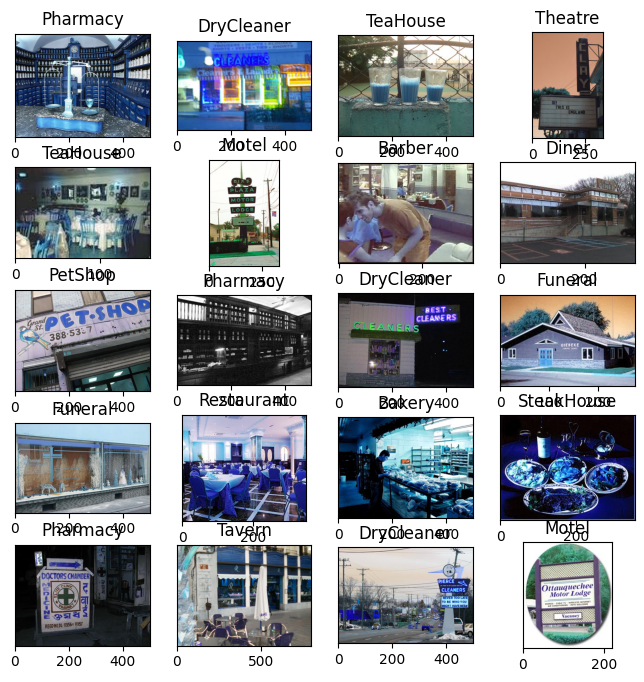


class distribution with data size of:  16179


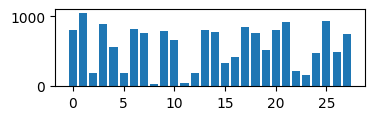

----------------------------------------------------
[INFO]: split: 0 | path: ./data/context
[INFO]: mode: test | split_file: ./data/context/split_0.json
Total num classes: 28


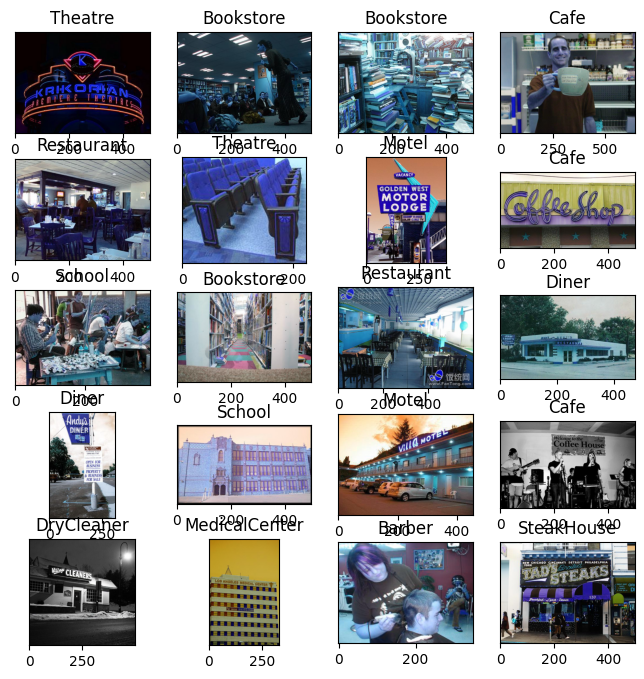


class distribution with data size of:  8076


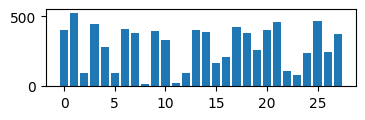

----------------------------------------------------
Num classes: 28


Using cache found in /user/HS502/sk02100/.cache/torch/hub/pytorch_vision_v0.10.0


Pre-saved weights @ ./outputs/context are ['3', '4', '5']


  0%|          | 0/127 [00:02<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [10]:
dataloaders = get_dataloaders(['context'], train_batch_size=128, val_batch_size=32)
opt_dir = {"bottle":"./outputs/bottle/", "context":"./outputs/context"}
loaded_model_weights = {"bottle":"", "context":""}
final_models = {}
device = 'cpu' #torch.device("cuda:0") if torch.cuda.is_available() else 'cpu'

for d_type in dataloaders:
    start = 0
    print("Num classes:", dataloaders[d_type]['num_classes'])
    model = CustomModel(num_classes=dataloaders[d_type]['num_classes'])
    # print(summary(model.to(device), (3,224,224)))
    
    if loaded_model_weights[d_type] != "":
        start = int(loaded_model_weights[d_type].split("/")[-2])
        print(f"[INFO] Loading model for {d_type} from epoch: {start}")
        model.load_state_dict(torch.load(loaded_model_weights[d_type])['model'])

    train_obj = Trainer(
        model=model,
        train_dataloader=dataloaders[d_type]['train'],
        val_dataloader=dataloaders[d_type]['test'],
        output_dir=opt_dir[d_type],
        start=start+1,
        epochs=10,
        d_type=d_type,
        num_classes=dataloaders[d_type]['num_classes']
    )
    train_obj.train()
    final_models[d_type] = train_obj

In [ ]:
# !pip install ftfy regex tqdm
# !pip install git+https://github.com/openai/CLIP.git

In [11]:
import clip

In [31]:
class ClipModel(nn.Module):
    def __init__(self, device):
        super().__init__()
        with open('data/context/classes.json','r') as fp:
            classes_labels = json.load(fp)
        self.class_labels = list(classes_labels.values())
        self.text_embeds = clip.tokenize(self.class_labels).to(device)
        self.model, self.preprocess = clip.load("ViT-B/32", device=device)

    def forward(self, image, label_name, return_ftrs=False, mode='val'):

        # image = self.preprocess(Image.open("CLIP.png")).unsqueeze(0).to(device)
        # text = clip.tokenize(list(label_name)).to(device)
        # print(label_name)
        image_features = self.model.encode_image(image)
        text_features = self.model.encode_text(self.text_embeds)
        
        logits_per_image, logits_per_text = self.model(image, self.text_embeds)

        return logits_per_image, image_features, text_features

In [32]:
clip_model = ClipModel('cpu')

[INFO]: split: 0 | path: ./data/context
[INFO]: mode: train | split_file: ./data/context/split_0.json
Total num classes: 28


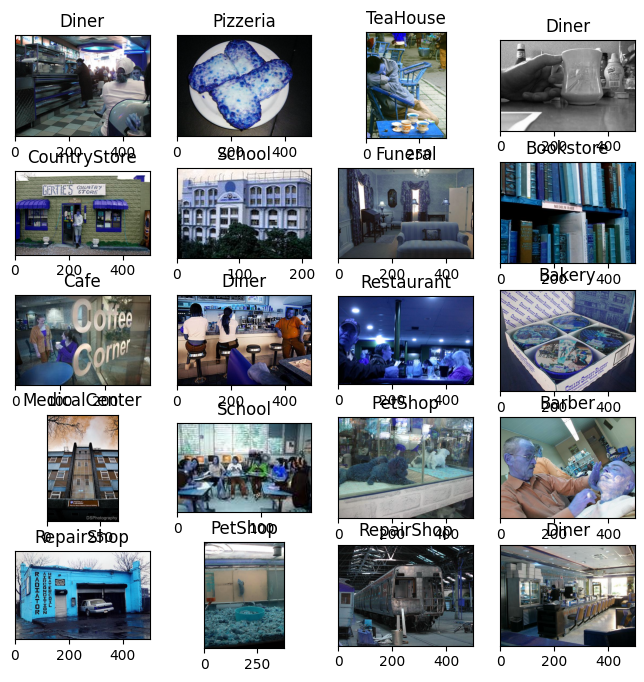


class distribution with data size of:  16179


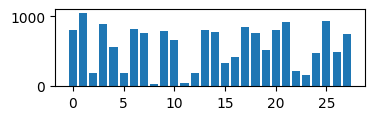

----------------------------------------------------
[INFO]: split: 0 | path: ./data/context
[INFO]: mode: test | split_file: ./data/context/split_0.json
Total num classes: 28


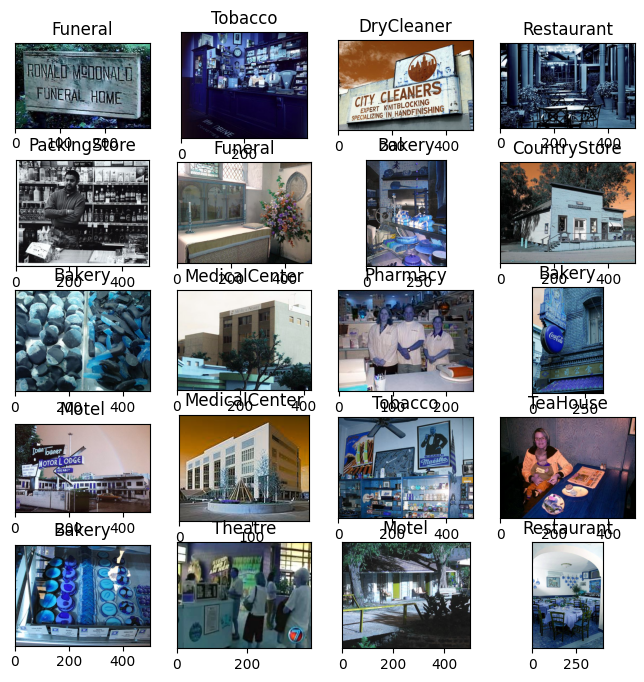


class distribution with data size of:  8076


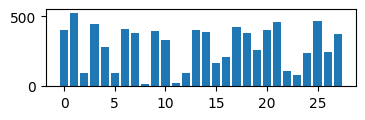

----------------------------------------------------


In [33]:
d_type = 'context'
dataloaders = get_dataloaders([d_type], train_batch_size=128, val_batch_size=32)

dataloader = dataloaders[d_type]['test']
dataloader.transform = clip_model.preprocess

In [34]:
get_performance(clip_model, dataloader, device='cpu',
                num_classes=dataloaders[d_type]['num_classes'],
                double_headed_encoder=True)

100%|██████████| 253/253 [14:39<00:00,  3.48s/it]





              precision    recall  f1-score   support

           0       0.85      0.78      0.81       404
           1       0.93      0.78      0.85       524
           2       0.12      0.26      0.16        95
           3       0.79      0.91      0.84       444
           4       0.53      0.51      0.52       279
           5       0.40      0.68      0.51        95
           6       0.53      0.62      0.57       408
           7       0.69      0.53      0.60       378
           8       0.04      0.64      0.07        14
           9       0.83      0.82      0.82       398
          10       0.87      0.34      0.49       330
          11       0.50      0.33      0.40        24
          12       0.62      0.84      0.71        92
          13       0.59      0.83      0.69       403
          14       0.09      0.02      0.03       389
          15       0.37      0.80      0.51       165
          16       0.74      0.91      0.81       208
          17       0.60 

{0: 0.8005453162492542,
 1: 0.8125597012778156,
 2: 0.11014711599021626,
 3: 0.8952269194606227,
 4: 0.3690893707376896,
 5: 0.5178261282134616,
 6: 0.5387827338049015,
 7: 0.5073408317524427,
 8: 0.4219062148123933,
 9: 0.8203114134587672,
 10: 0.3586672300245435,
 11: 0.17981150793650794,
 12: 0.7579697567239649,
 13: 0.7278763938603676,
 14: 0.0028817915259272777,
 15: 0.7138448041321879,
 16: 0.9115229977812815,
 17: 0.8041528924049004,
 18: 0.8659790754362886,
 19: 0.6375150749813737,
 20: 0.4203881121846099,
 21: 0.3751757336114529,
 22: 0.5007941931527551,
 23: 0.33742223959615264,
 24: 0.31332166210298457,
 25: 0.7072796752754134,
 26: 0.2705545198520868,
 27: 0.7815949885662474}

In [35]:
map_dict = {0: 0.8005453162492542,
 1: 0.8125597012778156,
 2: 0.11014711599021626,
 3: 0.8952269194606227,
 4: 0.3690893707376896,
 5: 0.5178261282134616,
 6: 0.5387827338049015,
 7: 0.5073408317524427,
 8: 0.4219062148123933,
 9: 0.8203114134587672,
 10: 0.3586672300245435,
 11: 0.17981150793650794,
 12: 0.7579697567239649,
 13: 0.7278763938603676,
 14: 0.0028817915259272777,
 15: 0.7138448041321879,
 16: 0.9115229977812815,
 17: 0.8041528924049004,
 18: 0.8659790754362886,
 19: 0.6375150749813737,
 20: 0.4203881121846099,
 21: 0.3751757336114529,
 22: 0.5007941931527551,
 23: 0.33742223959615264,
 24: 0.31332166210298457,
 25: 0.7072796752754134,
 26: 0.2705545198520868,
 27: 0.7815949885662474}

In [36]:
print("AP:", np.array(list(map_dict.values())).mean())

0.5521602998180933

In [39]:
config_dict={
            "context":{"path":"data/context","split":0}
            }
            
score_dict = {}
for d_type in config_dict:

    overall_map=0
    print(f"----------{d_type}-------------")
    for split in range(0,3):
        config_dict[d_type]['split'] = split
        dataloaders = get_dataloaders([d_type], train_batch_size=128, val_batch_size=32, config_dict=config_dict, verbose=0)
        loaded_model = ClipModel('cpu') # model_dict[d_type]
        print(dataloaders)
        map_dict = get_performance(loaded_model, #loaded_model.to("cuda").eval(),
                        dataloaders[d_type]["test"],
                        num_classes=dataloaders[d_type]['num_classes'],
                        device='cpu',
                        double_headed_encoder=True)

        print(f"mAP for split{split}:", np.array(list(map_dict.values())).mean())
        overall_map += np.array(list(map_dict.values())).mean()
    
    score_dict[d_type] = overall_map/3
    
print(score_dict)

----------context-------------
[INFO]: split: 0 | path: data/context
[INFO]: mode: train | split_file: data/context/split_0.json
Total num classes: 28
[INFO]: split: 0 | path: data/context
[INFO]: mode: test | split_file: data/context/split_0.json
Total num classes: 28
{'context': {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f11e123d130>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f11e123dd90>, 'num_classes': 28}}


100%|██████████| 253/253 [14:38<00:00,  3.47s/it]





              precision    recall  f1-score   support

           0       0.85      0.78      0.81       404
           1       0.93      0.78      0.85       524
           2       0.12      0.26      0.16        95
           3       0.79      0.91      0.84       444
           4       0.53      0.51      0.52       279
           5       0.40      0.68      0.51        95
           6       0.53      0.62      0.57       408
           7       0.69      0.53      0.60       378
           8       0.04      0.64      0.07        14
           9       0.83      0.82      0.82       398
          10       0.87      0.34      0.49       330
          11       0.50      0.33      0.40        24
          12       0.62      0.84      0.71        92
          13       0.59      0.83      0.69       403
          14       0.09      0.02      0.03       389
          15       0.37      0.80      0.51       165
          16       0.74      0.91      0.81       208
          17       0.60 

 20%|█▉        | 50/253 [02:52<11:50,  3.50s/it]

## final testing

#### mAP

In [78]:
def load_saved_model(load_path, num_classes):
    load_model = CustomModel(num_classes=num_classes)
    load_model.load_state_dict(torch.load(load_path)['model'])
    return load_model

In [80]:
model_dict = {"bottle":load_saved_model(load_path="outputs/bottle/2/2.pth", num_classes=20),
              "context": load_saved_model(load_path="outputs/context/5/5.pth",num_classes=28)}

Using cache found in /user/HS502/sk02100/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /user/HS502/sk02100/.cache/torch/hub/pytorch_vision_v0.10.0


In [83]:
config_dict={
            "bottle":{"path":"data/bottle", "split":0},
            "context":{"path":"data/context","split":0}
            }

In [85]:
score_dict = {}
for d_type in config_dict:

    overall_map=0
    print(f"----------{d_type}-------------")
    for split in range(0,3):
        config_dict[d_type]['split'] = split
        dataloaders = get_dataloaders([d_type], train_batch_size=128, val_batch_size=32, config_dict=config_dict, verbose=0)
        loaded_model = ClipModel() # model_dict[d_type]
        print(dataloaders)
        map_dict = get_performance(loaded_model.to("cuda").eval(),
                        dataloaders[d_type]["test"],
                        num_classes=dataloaders[d_type]['num_classes'])

        print(f"mAP for split{split}:", np.array(list(map_dict.values())).mean())
        overall_map += np.array(list(map_dict.values())).mean()
    
    score_dict[d_type] = overall_map/3
    
print(score_dict)
        



----------bottle-------------
[INFO]: split: 0 | path: data/bottle
[INFO]: mode: train | split_file: data/bottle/split_0.json
Total num classes: 20
[INFO]: split: 0 | path: data/bottle
[INFO]: mode: test | split_file: data/bottle/split_0.json
Total num classes: 20
{'bottle': {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f657151ed90>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f657151e790>, 'num_classes': 20}}


100%|██████████| 193/193 [00:23<00:00,  8.16it/s]





              precision    recall  f1-score   support

           0       0.55      0.52      0.54       419
           1       0.52      0.55      0.54       390
           2       0.78      0.89      0.83       422
           3       0.82      0.94      0.88       411
           4       0.26      0.45      0.33       176
           5       0.53      0.63      0.58        57
           6       0.26      0.27      0.26       138
           7       0.59      0.41      0.49       338
           8       0.40      0.32      0.35       125
           9       0.78      0.72      0.75       427
          10       0.81      0.34      0.48       123
          11       0.50      0.23      0.32        86
          12       0.62      0.56      0.59       396
          13       0.83      0.87      0.85       490
          14       0.48      0.36      0.41       337
          15       0.34      0.45      0.39       166
          16       0.71      0.63      0.67       331
          17       0.62 

100%|██████████| 193/193 [00:30<00:00,  6.29it/s]





              precision    recall  f1-score   support

           0       0.71      0.62      0.66       443
           1       0.64      0.72      0.68       369
           2       0.82      0.95      0.88       412
           3       0.86      0.96      0.90       423
           4       0.52      0.75      0.61       218
           5       0.70      0.76      0.73        63
           6       0.46      0.44      0.45       147
           7       0.77      0.48      0.59       341
           8       0.70      0.49      0.58       138
           9       0.85      0.88      0.86       378
          10       0.89      0.43      0.58       111
          11       0.70      0.38      0.49        79
          12       0.82      0.72      0.77       418
          13       0.90      0.95      0.92       492
          14       0.68      0.55      0.61       352
          15       0.49      0.65      0.56       151
          16       0.84      0.72      0.77       303
          17       0.67 

100%|██████████| 193/193 [00:30<00:00,  6.34it/s]





              precision    recall  f1-score   support

           0       0.72      0.67      0.69       415
           1       0.69      0.71      0.70       441
           2       0.85      0.96      0.90       412
           3       0.90      0.97      0.94       394
           4       0.46      0.72      0.56       185
           5       0.75      0.82      0.78        72
           6       0.49      0.51      0.50       146
           7       0.78      0.49      0.61       368
           8       0.63      0.56      0.59       157
           9       0.83      0.85      0.84       401
          10       0.89      0.44      0.59       108
          11       0.70      0.43      0.54        76
          12       0.77      0.70      0.74       385
          13       0.89      0.92      0.91       498
          14       0.67      0.54      0.60       325
          15       0.53      0.67      0.59       165
          16       0.83      0.68      0.75       324
          17       0.73 

100%|██████████| 253/253 [00:31<00:00,  8.00it/s]





              precision    recall  f1-score   support

           0       0.78      0.64      0.70       404
           1       0.66      0.76      0.71       524
           2       0.30      0.52      0.38        95
           3       0.75      0.73      0.74       444
           4       0.31      0.30      0.31       279
           5       0.73      0.63      0.68        95
           6       0.58      0.56      0.57       408
           7       0.69      0.71      0.70       378
           8       0.10      0.07      0.08        14
           9       0.44      0.52      0.48       398
          10       0.54      0.66      0.60       330
          11       0.61      0.79      0.69        24
          12       0.72      0.75      0.73        92
          13       0.60      0.72      0.65       403
          14       0.62      0.57      0.59       389
          15       0.44      0.40      0.42       165
          16       0.80      0.72      0.76       208
          17       0.74 

100%|██████████| 253/253 [00:31<00:00,  8.16it/s]





              precision    recall  f1-score   support

           0       0.96      0.85      0.90       404
           1       0.86      0.93      0.90       524
           2       0.62      0.98      0.76        95
           3       0.89      0.93      0.91       444
           4       0.75      0.70      0.73       279
           5       0.92      0.85      0.89        95
           6       0.85      0.80      0.83       408
           7       0.88      0.87      0.87       378
           8       0.67      1.00      0.80        14
           9       0.71      0.84      0.77       398
          10       0.87      0.92      0.89       330
          11       0.73      0.92      0.81        24
          12       0.94      0.87      0.90        92
          13       0.82      0.92      0.87       403
          14       0.86      0.80      0.83       389
          15       0.87      0.87      0.87       165
          16       0.96      0.91      0.93       208
          17       0.93 

100%|██████████| 254/254 [00:31<00:00,  8.14it/s]





              precision    recall  f1-score   support

           0       0.95      0.83      0.89       406
           1       0.89      0.93      0.91       525
           2       0.61      0.99      0.76        97
           3       0.89      0.92      0.91       445
           4       0.76      0.64      0.69       281
           5       0.92      0.88      0.90        97
           6       0.86      0.85      0.86       408
           7       0.91      0.92      0.91       380
           8       0.71      1.00      0.83        15
           9       0.72      0.82      0.77       399
          10       0.87      0.93      0.90       331
          11       0.86      0.96      0.91        26
          12       0.92      0.93      0.92        94
          13       0.84      0.96      0.89       403
          14       0.84      0.80      0.82       389
          15       0.82      0.88      0.85       165
          16       0.95      0.92      0.93       208
          17       0.95 